# MNLI task 를 해결하는 모델 만들기

- MNLI(Multi-Genre Natural Language Inference)는 자연어 추론(Natural Language Inference) 작업의 한 유형입니다. 
- 이 작업은 두 개의 문장(전제와 가설)이 주어졌을 때, 그들 사이의 논리적 관계를 판단하는 것입니다.
- MNLI에서는 세 가지 관계 중 하나로 분류합니다.
    - 함의(entailment): 전제가 가설을 논리적으로 함의하는 경우
    - 모순(contradiction): 전제가 가설과 모순되는 경우
    - 중립(neutral): 전제와 가설 사이에 명확한 논리적 관계가 없는 경우

## 데이터셋
- [nyu-mll/glue](https://huggingface.co/datasets/nyu-mll/glue) 에서 MNLI task 에 해당하는 데이터셋을 사용합니다.
- "nyu-mll/glue"는 New York University Machine Learning Lab에서 제공하는 GLUE 벤치마크 데이터셋입니다.
- GLUE 벤치마크의 여러 개의 task 중 "mnli"를 가져와서 사용합니다.
- 데이터셋은 아래와 같이 구성되어 있습니다.
    - train:
    - validation_matched:
    - validation_mismatched:
    - test_matched:
    - test_mismatched:
- 데이터셋의 각 데이터는 아래와 같이 구성되어 있습니다.
    - premise: 전제 문장
    - hypothesis: 가설 문장
    - label: 두 문장의 관계로, entailment (0), neutral (1), contradiction (2) 중 하나를 가집니다.

In [1]:
import pprint
from datasets import load_dataset

dataset = load_dataset("nyu-mll/glue", "mnli")
print(dataset)
pprint.pprint(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})
{'hypothesis': 'Product and geography are what make cream skimming work. ',
 'idx': 0,
 'label': 1,
 'premise': 'Conceptually cream skimming has two basic dimensions - product '
            'and geography.'}


In [2]:
NUM_DS_LABELS = 3
id2label = {0: "ENTAILMENT", 1: "NEUTRAL", 2: "CONTRADICTION"}
label2id = {"ENTAILMENT": 0, "NEUTRAL": 1, "CONTRADICTION": 2}

In [3]:
# dependencies
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
)

import evaluate
import numpy as np

import matplotlib.pyplot as plt

In [4]:
# compute metrics 정의
accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

## MNLI 용 파인 튜닝된 DistilBERT 모델 만들기

### DistilBERT 로딩

In [5]:
fine_tuning_d_bert = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=NUM_DS_LABELS,
    id2label=id2label,
    label2id=label2id,
)

# freezing
for param in fine_tuning_d_bert.distilbert.parameters():
    param.requires_grad = False

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### DistilBERT 의 Tokenizer 로딩

In [6]:
d_bert_tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

### 데이터셋 전처리

In [7]:
def preprocess_function_by_d_bert_tokenizer(data):
    return d_bert_tokenizer(
        data["premise"], data["hypothesis"], truncation=True, padding="max_length"
    )


d_bert_tokenized_ds = dataset.map(preprocess_function_by_d_bert_tokenizer, batched=True)

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

### 데이터셋 분할

In [8]:
d_bert_ds_split = d_bert_tokenized_ds["train"].train_test_split(test_size=0.2)
d_bert_train_ds = d_bert_ds_split["train"]
d_bert_val_ds = d_bert_ds_split["test"]

len(d_bert_train_ds), len(d_bert_val_ds)

(314161, 78541)

### TrainingArguments 설정

In [9]:
DISTILBERT_DIR_OUTPUT = "../data/fine_tuned_distilbert_for_mnli"
DISTILBERT_EPOCHS = 10
DISTILBERT_LEARNING_RATE = 1e-3
DISTILBERT_BATCH_SIZE = 64

In [10]:
d_bert_training_args = TrainingArguments(
    output_dir=DISTILBERT_DIR_OUTPUT,
    logging_dir=f"{DISTILBERT_DIR_OUTPUT}/logs",
    logging_strategy="epoch",
    num_train_epochs=DISTILBERT_EPOCHS,
    per_device_train_batch_size=DISTILBERT_BATCH_SIZE,
    per_device_eval_batch_size=DISTILBERT_BATCH_SIZE,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=DISTILBERT_LEARNING_RATE,
    load_best_model_at_end=True,
)
d_bert_training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,
evaluation_st

### Trainer 설정

In [11]:
d_bert_trainer = Trainer(
    model=fine_tuning_d_bert,
    args=d_bert_training_args,
    train_dataset=d_bert_train_ds,
    eval_dataset=d_bert_val_ds,
    compute_metrics=compute_metrics,
    tokenizer=d_bert_tokenizer,
)

In [12]:
d_bert_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.022400,0.987243,0.509237
2,1.000500,0.978882,0.517373
3,0.993000,0.968543,0.524516
4,0.986200,0.965623,0.524401
5,0.981500,0.957938,0.534014
6,0.978000,0.965041,0.527304
7,0.973800,0.954397,0.536981
8,0.970500,0.950197,0.538165
9,0.967300,0.949461,0.540202
10,0.964400,0.948051,0.540431


TrainOutput(global_step=49090, training_loss=0.9837526080127063, metrics={'train_runtime': 6597.9459, 'train_samples_per_second': 476.15, 'train_steps_per_second': 7.44, 'total_flos': 4.1616832593060864e+17, 'train_loss': 0.9837526080127063, 'epoch': 10.0})

In [13]:
d_bert_trainer.save_model()

In [14]:
fine_tuned_d_bert_results = d_bert_trainer.evaluate(
    d_bert_tokenized_ds["validation_matched"]
)
fine_tuned_d_bert_results

{'eval_loss': 0.9430901408195496,
 'eval_accuracy': 0.543046357615894,
 'eval_runtime': 15.7325,
 'eval_samples_per_second': 623.866,
 'eval_steps_per_second': 9.789,
 'epoch': 10.0}

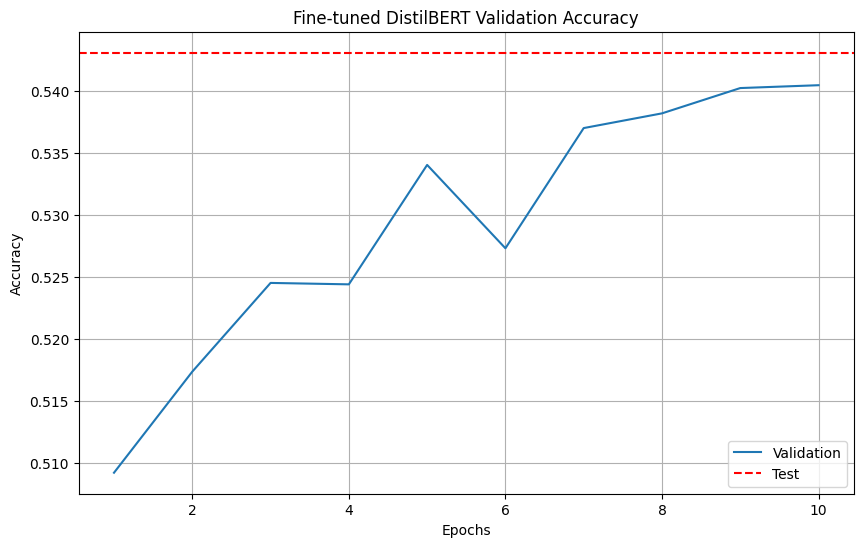

Final Validation Accuracy: 0.5404
Final Test Accuracy: 0.5430


In [15]:
d_bert_accuracies = [
    log["eval_accuracy"]
    for log in d_bert_trainer.state.log_history
    if "eval_accuracy" in log
]


epochs = range(1, DISTILBERT_EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, d_bert_accuracies[:-1], label="Validation")
plt.axhline(y=d_bert_accuracies[-1], color="r", linestyle="--", label="Test")
plt.title("Fine-tuned DistilBERT Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Validation Accuracy: {d_bert_accuracies[-2]:.4f}")
print(f"Final Test Accuracy: {d_bert_accuracies[-1]:.4f}")